# Hermite polynomials for local function approximation

In [1]:
import math
import torch
import numpy as np
import scipy.special
import matplotlib.pyplot as plt

In [2]:
# https://en.wikipedia.org/wiki/Hermite_polynomials
COEF = [
    [1],
    [0, 2],
    [-2, 0, 4],
    [0, -12, 0, 8],
    [12, 0, -48, 0, 16],
    [0, 120, 0, -160, 0, 32],
    [-120, 0, 720, 0, -480, 0, 64],
    [0, -1680, 0, 3360, 0, -1344, 0, 128],
    [1680, 0, -13440, 0, 13440, 0, -3584, 0, 256],
    [0, 30240, 0, -80640, 0, 48348, 0, -9216, 0, 512],
]
COEF = [
    scipy.special.hermite(n).coef[::-1].tolist() for n in range(100)
]
coef = torch.tensor(
    [row + [0.] * (len(COEF) - len(row)) for row in COEF]
)
# Orthonormalize.
for n, row in enumerate(coef):
    row *= (2 ** n * math.factorial(n) * math.pi ** 0.5) ** -0.5

In [3]:
# https://en.wikipedia.org/wiki/Hermite_polynomials#Hermite_functions
def hermite(w: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    n = w.shape[-1]
    p = x.square().mul(-0.5).exp()
    # powers = x.unsqueeze(-1) ** torch.arange(n, dtype=x.dtype)
    powers = torch.vander(x.reshape(-1), n, increasing=True).reshape(x.shape + (-1,))
    # TODO numerically stabilize via logspace
    return p * (w.unsqueeze(-2) @ coef[:n, :n] @ powers.unsqueeze(-1)).squeeze(-1).squeeze(-1)

In [4]:
def print_ips(n):
    w = torch.eye(n).unsqueeze(-2)
    x = torch.linspace(-n, n, 500)
    dx = (x[-1] - x[0]) / (len(x) - 1)
    y = hermite(w, x)
    ips = torch.einsum("ip,jp->ij", y, y) * dx
    with np.printoptions(precision=1, linewidth=100):
        print(ips.numpy())
    print(f"error = {(ips - torch.eye(n)).max():0.3g}")
    
print_ips(8)

[[ 1.0e+00  3.4e-08 -1.4e-07 -2.0e-08  1.6e-07  3.3e-08 -1.2e-07 -9.6e-09]
 [ 3.4e-08  1.0e+00  1.1e-08  6.5e-08  4.1e-09 -7.9e-08  3.8e-08 -8.7e-08]
 [-1.4e-07  1.1e-08  1.0e+00 -5.2e-08  2.3e-08  4.0e-08 -2.1e-07 -5.2e-08]
 [-2.0e-08  6.5e-08 -5.2e-08  1.0e+00  1.7e-08 -3.6e-07 -7.0e-08  3.0e-07]
 [ 1.6e-07  4.1e-09  2.3e-08  1.7e-08  1.0e+00 -1.1e-07  4.4e-09 -1.4e-08]
 [ 3.3e-08 -7.9e-08  4.0e-08 -3.6e-07 -1.1e-07  1.0e+00  7.0e-08  1.1e-07]
 [-1.2e-07  3.8e-08 -2.1e-07 -7.0e-08  4.4e-09  7.0e-08  1.0e+00  3.6e-08]
 [-9.6e-09 -8.7e-08 -5.2e-08  3.0e-07 -1.4e-08  1.1e-07  3.6e-08  1.0e+00]]
error = 2.98e-07


In [5]:
def plot_random(n=10, count=8, num_points=500):
    x = torch.linspace(-2 * n**0.5, 2 * n **0.5, num_points)
    w = torch.randn(count, 1, n)
    y = hermite(w, x)
    assert y.shape == (count, num_points), y.shape
    plt.figure(figsize=(8, 3))
    plt.plot(x.expand_as(y).T, y.T)

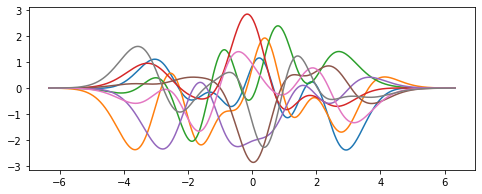

In [6]:
plot_random()

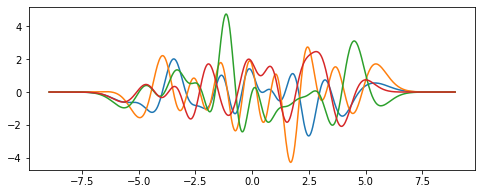

In [7]:
plot_random(20, 4)

## Low-discrepancy distributions of points